In [9]:
! unzip archive\ \(2\).zip

Archive:  archive (2).zip
  inflating: IMDB Dataset.csv        


In [5]:
import re
import string
from time import time 

import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
nltk.download('stopwords')
punct = string.punctuation
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()
data_path = '/content/IMDB Dataset.csv'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def stratified_split(data, split_ratio=0.95, seed=10):
    # could have simply used train_test_split with stratify as parameter
    # but implementing just for fun 
    np.random.seed(seed)
    positive_data = data[data['sentiment']=='positive']
    negative_data = data[data['sentiment']=='negative']
    num_pos = len(positive_data)
    num_neg = len(negative_data)
    random_pos_permut = np.random.permutation(num_pos)
    random_neg_permut = np.random.permutation(num_neg)
    train_pos_data = data.iloc[random_pos_permut[:int(split_ratio*num_pos)], :].values
    test_pos_data = data.iloc[random_pos_permut[int(split_ratio*num_pos):], :].values
    train_neg_data = data.iloc[random_neg_permut[:int(split_ratio*num_neg)], :].values
    test_neg_data = data.iloc[random_neg_permut[int(split_ratio*num_neg):], :].values
    train_data = np.concatenate((train_pos_data, train_neg_data))
    test_data = np.concatenate((test_pos_data, test_neg_data))
    return pd.DataFrame(train_data, columns=data.columns), pd.DataFrame(test_data, columns=data.columns)

In [10]:
data = pd.read_csv(data_path)
print(len(data))
data.head()

50000


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [12]:
train_data, test_data = stratified_split(data, split_ratio=0.75)

In [13]:
print(len(train_data))
train_data.head()

37500


,review,sentiment
0,or any stories reminiscent of the Leopold and ...,positive
1,i am surprised so few have good words for this...,positive
2,Rabbit Seasoning is one of three cartoons that...,positive
3,"I have to admit that this ""re-imagining"" of th...",negative
4,"Preston Waters, a 11 years old boy,has problem...",positive


In [14]:
print(len(test_data))
test_data.head()

12500


,review,sentiment
0,While I have seen and enjoyed similar movies t...,negative
1,"I think ""Anyway..."" is a kick-ass movie. Reall...",positive
2,This movie tries to say something profound; I'...,negative
3,I am a Shakespeare lover since childhood. I am...,negative
4,<br /><br />I have to admit to enjoying bad mo...,positive


number of negative and positive reviews [18861 18639]


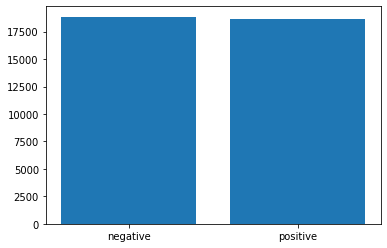

In [15]:
value_counts = train_data['sentiment'].value_counts()
print(f'number of negative and positive reviews {value_counts.values}')
plt.bar(value_counts.keys(), value_counts.values)
plt.show()

In [16]:
def preprocessing(string, stopwords):
    string  = string.lower() # converting to the lowercase letters
    string = re.sub(r'[^a-zA-Z]', ' ', string)
    tokens = re.split(' ', string) # splitting the sentence into with delimeter being white space
    
    clean_tokens = []
    for word in tokens:
        if word!='' and word not in stopwords:
            clean_tokens.append(word)
          
    return clean_tokens

In [17]:
def build_vocab_word2ind_ind2word(train_data, closed_vocab_len=1000):
    # i will keep vocab_len to be at the max 10000
    open_vocab = {}
    lengths = [] #  required for further analysis
    for index in range(len(train_data)):
        sentence_len = 0
        for word in preprocessing(train_data['review'][index] ,stopwords_english):
            if word in open_vocab.keys():
                open_vocab[word]+=1
            else:
                open_vocab[word]=1
            sentence_len+=1
        lengths.append(sentence_len) 
    open_vocab = sorted(open_vocab.items(), key=lambda x:x[1])
    open_vocab = open_vocab[::-1] # reversing
    #print(type(open_vocab))
    closed_vocab = dict(open_vocab[:closed_vocab_len])
    #print(type(closed_vocab))
    word2ind = {}
    ind2word = {}
    for x in closed_vocab.keys():
        word2ind[x] = len(word2ind) + 1
        ind2word[len(ind2word)+1] = x
        
    return open_vocab, closed_vocab, word2ind, ind2word, lengths

In [18]:
open_vocab, closed_vocab, word2ind, ind2word, lengths = build_vocab_word2ind_ind2word(train_data)
len(open_vocab), len(closed_vocab), len(lengths)

(72825, 1000, 37500)

count    37500.000000
mean       122.866080
std         92.679502
min          4.000000
25%         65.000000
50%         91.000000
75%        150.000000
max        955.000000
dtype: float64


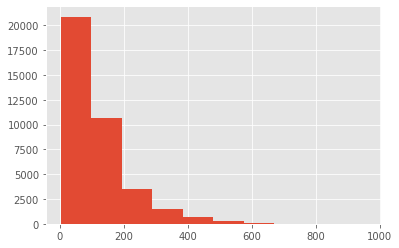

In [19]:
from matplotlib import style
style.use('ggplot')
pd.Series(lengths).hist()
print(pd.Series(lengths).describe())
plt.show()

In [20]:
def form_data(DATA, word2ind, max_len=400, type_='training'):
    
    ctr = 10
    data = []
    for i in range(len(DATA)):
        prep = preprocessing(DATA['review'][i], stopwords_english)
        if len(prep)<=max_len:
            temp_data = []
            for word in prep:
                # i am giving padding to be number 0 as our word2ind dict starts from 1 
                if word in word2ind.keys():
                    temp_data.append(word2ind[word]) 
            temp_data = [0]*(max_len-len(temp_data)) + temp_data  
            if DATA['sentiment'][i]=='positive':
                temp_data.append(1)
            else:
                temp_data.append(0)
            if (i+1)%(len(DATA)/10)==0:
                print(f'{ctr}% of {type_} data processed')
                ctr+=10
        data.append(temp_data)
    return torch.tensor(data).type(torch.LongTensor)

In [21]:
class SentimentAnalysis(nn.Module):
    def __init__(self, num_layers=2, vocab_size=1001, embedding_dim=64, hidden_dim=256, drop_prob=0.3, device=device):
        super(SentimentAnalysis, self).__init__()
       
        self.num_layers = num_layers  
        self.vocab_size = vocab_size  
        self.embedding_dim = embedding_dim  
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=1)
        
    def forward(self, x):
        # initializes hidden_state and cell state
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_dim)).to(device)
        hidden = (h0,c0)
        
        batch_size, seq_len = x.shape
        # input will be of shape (batch_size, max_len)  
        embeds = self.embedding(x) 
        lstm_out, hidden = self.lstm(embeds, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        lstm_out = self.dropout(lstm_out) 
        op = self.fc(lstm_out) 
        op = op.view(batch_size, seq_len) 
        op = op[:, -1]
        return op 

In [22]:
def save_checkpoint(state, filename='my_checkpoint.pth'):
   
    print("-> Saving CheckPoint")
    torch.save(state, filename)

In [23]:
def load_checkpoint(checkpoint, model):
   
    print("-> Loading CheckPoint")
    model.load_state_dict(checkpoint["state_dict"])

In [24]:
def train(loader, model, optimizer, loss_fn, scaler, scheduler, clip=5, device=device):
    '''
    it is the training procedure for one epoch of the network
    '''
    model.train()
    num_batches = len(loader)
    batches = tqdm(loader) # tqdm will be used to generate progress bars
    train_acc = 0
    for idx, batch in enumerate(batches, 0):
        inp = batch[:, :-1].to(device)  # shape is (32, max_len)
        target = batch[:, -1].type(torch.float32).to(device) # shape is (32,)
        
        # forward
        with torch.cuda.amp.autocast(): 
            pred = model(inp)
            loss = loss_fn(pred, target)
            
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)  # for exploding gradients problem
        scaler.step(optimizer)
        scaler.update()
        
        
        model.eval()
        with torch.no_grad():
            train_acc += ((pred>0).type(torch.float32)==target).sum().item()/(inp.shape[0])
        batches.set_postfix(loss = loss.item()) # loss of this current batch on current iteration 
        model.train()
        
    scheduler.step()
    train_acc/=num_batches
    print(f"Training accuracy is {train_acc*100}")

In [25]:
def test(loader, model):
    model.eval()
    num_batches = len(loader)
    test_acc = 0
    with torch.no_grad():
        # no tqdm will be used here as we have to just find the accuracy metric
        for idx, batch in enumerate(loader, 0):
            inp = batch[:, :-1].to(device)
            target = batch[:, -1].to(device)
            pred = model(inp)
            test_acc += ((pred>0).type(torch.float32)==target).sum().item()/(inp.shape[0])
    test_acc/=num_batches
    print(f"Testing accuracy is {test_acc*100}")
    model.train()

In [26]:
max_len = 400
batch_size = 32 
lr = 1e-3
num_epochs = 10

# setting up the dataset, dataloaders and vocabulary 
TRAIN_DATA = form_data(train_data, word2ind)
TEST_DATA = form_data(test_data, word2ind, type_='testing')
train_loader = torch.utils.data.DataLoader(TRAIN_DATA, batch_size=batch_size, shuffle=True, num_workers=2)
print("\n\n\n")
test_loader = torch.utils.data.DataLoader(TEST_DATA, batch_size=batch_size, shuffle=True, num_workers=2)
# criterion, optimizer. model

10% of training data processed
20% of training data processed
30% of training data processed
40% of training data processed
50% of training data processed
60% of training data processed
70% of training data processed
80% of training data processed
90% of training data processed
100% of training data processed
10% of testing data processed
20% of testing data processed
30% of testing data processed
40% of testing data processed
50% of testing data processed
60% of testing data processed
70% of testing data processed
80% of testing data processed
90% of testing data processed
100% of testing data processed






In [27]:
model = SentimentAnalysis().to(device)
criterion = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
print(model)

SentimentAnalysis(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [28]:
for epoch in range(num_epochs):
    model.train()
    train(train_loader, model, optimizer, criterion, scaler, scheduler)
    
    # save checkpoints 
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    # check accuracy  om test set
    test(test_loader, model)

100%|██████████| 1172/1172 [00:48<00:00, 24.05it/s, loss=0.527]


Training accuracy is 76.56554729400294
-> Saving CheckPoint
Testing accuracy is 80.3037084398977


100%|██████████| 1172/1172 [00:47<00:00, 24.49it/s, loss=0.174]


Training accuracy is 85.12349158946856
-> Saving CheckPoint
Testing accuracy is 86.5153452685422


100%|██████████| 1172/1172 [00:46<00:00, 25.28it/s, loss=0.455]


Training accuracy is 89.11887493905411
-> Saving CheckPoint
Testing accuracy is 88.57257033248082


100%|██████████| 1172/1172 [00:45<00:00, 25.52it/s, loss=0.183]


Training accuracy is 93.02131582155046
-> Saving CheckPoint
Testing accuracy is 91.0230179028133


100%|██████████| 1172/1172 [00:46<00:00, 25.26it/s, loss=0.0639]


Training accuracy is 94.55524744027304
-> Saving CheckPoint
Testing accuracy is 92.6854219948849


100%|██████████| 1172/1172 [00:46<00:00, 25.23it/s, loss=0.000556]


Training accuracy is 98.11486774744027
-> Saving CheckPoint
Testing accuracy is 94.10965473145781


100%|██████████| 1172/1172 [00:46<00:00, 25.14it/s, loss=8.68e-5]


Training accuracy is 98.81612627986348
-> Saving CheckPoint
Testing accuracy is 94.451726342711


100%|██████████| 1172/1172 [00:45<00:00, 25.72it/s, loss=0.0247]


Training accuracy is 99.15742320819113
-> Saving CheckPoint
Testing accuracy is 94.92806905370844


100%|██████████| 1172/1172 [00:45<00:00, 25.74it/s, loss=1.24e-6]


Training accuracy is 99.47738907849829
-> Saving CheckPoint
Testing accuracy is 95.23976982097186


100%|██████████| 1172/1172 [00:45<00:00, 25.98it/s, loss=0.0051]


Training accuracy is 99.70669795221842
-> Saving CheckPoint
Testing accuracy is 95.33567774936061


In [29]:
def predict_sentiment(text):
    prep = preprocessing(text, stopwords_english)
    prep = prep[:max_len] # length or the text can be greater than max_len
    prep = [word2ind[word] for word in prep if word in word2ind.keys()]
    prep = [0]*(max_len-len(prep)) + prep
    prep = torch.tensor(prep).type(torch.LongTensor)
    prep = prep.reshape(1, prep.shape[0]).to(device)
    op = model(prep)
    op = torch.sigmoid(op)
    if op[0]>0.5:
        print("This review seems poistive to us with a probability of ", op[0].item())
    else:
        print("This review seems negative to us with a probability of ", 1-op[0].item())

In [30]:
index = 11
print(data['review'][index])
print("\n\n\n")
predict_sentiment(data['review'][index])

I saw this movie when I was about 12 when it came out. I recall the scariest scene was the big bird eating men dangling helplessly from parachutes right out of the air. The horror. The horror.<br /><br />As a young kid going to these cheesy B films on Saturday afternoons, I still was tired of the formula for these monster type movies that usually included the hero, a beautiful woman who might be the daughter of a professor and a happy resolution when the monster died in the end. I didn't care much for the romantic angle as a 12 year old and the predictable plots. I love them now for the unintentional humor.<br /><br />But, about a year or so later, I saw Psycho when it came out and I loved that the star, Janet Leigh, was bumped off early in the film. I sat up and took notice at that point. Since screenwriters are making up the story, make it up to be as scary as possible and not from a well-worn formula. There are no rules.




This review seems negative to us with a probability of  0.